In [5]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import methods
import pymaster as nmt
from importlib import reload
from tqdm import tqdm
from scipy.linalg import block_diag

In [6]:
nside = 512
npix = 12*nside**2
lmax = 3*nside-1

In [7]:
reload(methods)
ell_input, TT, TE, EE, BB, PP = np.loadtxt('cl.txt', unpack=True)
# input_cls = np.array([TT, EE, np.zeros_like(EE), TE]) #no BB
input_cls = np.array([TT, EE, BB, TE]) 
input_cls /= ell_input*(ell_input+1)/2/np.pi 
for c in input_cls: c[0] = 0 
input_cls = input_cls[:,:lmax+1]
ell_input = ell_input[:lmax+1]
c2d = ell_input*(ell_input+1)/2/np.pi

/tmp/ipykernel_30314/1896370247.py:5: RuntimeWarning: invalid value encountered in true_divide
  input_cls /= ell_input*(ell_input+1)/2/np.pi


7.317829132080078


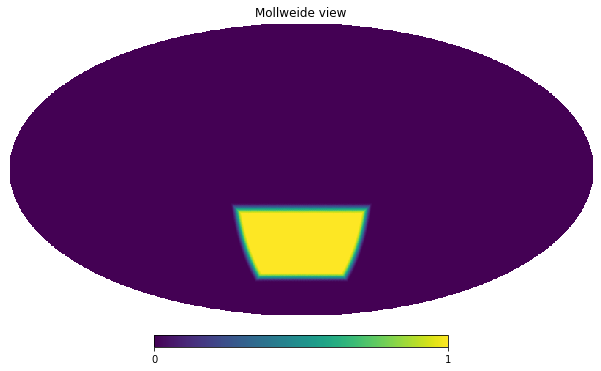

In [8]:
reload(methods)
mask = methods.get_mask(nside)
mask_apo = nmt.mask_apodization(mask, 6, apotype='C2')
hp.mollview(mask_apo)
print(len(mask_apo[(mask_apo!=0)])/npix *100)

In [120]:
reload(methods)
sigmab = hp.nside2resol(nside)
fwhm = methods.sigma2fwhm(sigmab)
bl = methods.get_bl(nside)
mll = methods.get_mll(mask_apo, nside, purify_b=True)
# mll = methods.get_mll(mask_apo, nside, pol=False, purify_b=False)
b = nmt.NmtBin.from_nside_linear(nside, 32)
ells = b.get_effective_ells()
P_bl = methods.get_P_bl(ells, nside)
Q_lb = methods.get_Q_lb(ells, nside)
c2db = ells * (ells+1) /2/np.pi

In [121]:
input_map = hp.synfast(input_cls, nside, new=True)

In [122]:
f = nmt.NmtField(mask_apo, mask*[input_map[1], input_map[2]], purify_b=True)
cl_nmt = nmt.compute_full_master(f, f, b)

In [123]:
ana_input = hp.anafast(mask_apo * input_map)

ana_vec = np.array([ana_input[1], ana_input[4], ana_input[4], ana_input[2]]).flatten()

P_bl_block = block_diag(P_bl, P_bl, P_bl, P_bl)
Q_lb_block = block_diag(Q_lb, Q_lb, Q_lb, Q_lb)

K_bb_inv = np.linalg.inv(P_bl_block @ mll @ Q_lb_block)

cl = (K_bb_inv @ P_bl_block @ ana_vec).reshape(4, len(ells))

[]

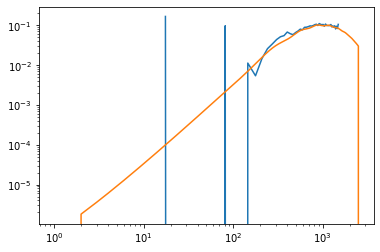

In [127]:
plt.plot(ells, c2db*cl[3])
# plt.plot(ells, c2db*cl_nmt[3])
plt.plot(BB)
plt.loglog()